In [69]:
%load_ext autoreload
%autoreload 2
import re
import ast
import time
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from helpers import *
sns.color_palette("rocket")
plt.style.use('ggplot')
pd.set_option('display.max_columns', 50)
sns.set_style('whitegrid')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Table of Contents
1. [Data Overview](#section-1)
    1. [Load the data](#section-1.1)
    2. [Is there missing values ?](#section-1.2)
    3. [General statistics](#section-1.3)
    4. [Augmenting the CMU dataset](#section-1.4)
    5. [Cleaning the data](#section-1.5)
    6. [(Optional) Completing the data](#section-1.6)
2. [Exploratory Data Analysis](#section-2)
3. [Demographic Recommandation System](#section-3)
4. [Collaborative filtering Recommandation System](#section-4)
5. [Content-based filtering Recommandation System](#section-5)
6. [Hybrid filtering Recommandation System](#section-6)

## 1. Data Overview
<a id='section-1'></a>

### 1.1 Load the data 
<a id='section-1.1'></a>

We first load the data and inspect what information we have in the CMU dataset.

In [2]:
# CMU dataset 
data_folder = './MovieSummaries/MovieSummaries/'

#paths to files
plot_summaries_path = data_folder + 'plot_summaries.txt'
movie_metadata_path = data_folder + 'movie.metadata.tsv'
character_metadata_path = data_folder + 'character.metadata.tsv'

# load the data
# 1. Plot summaries data
df_cmu_plot = pd.read_csv(plot_summaries_path, delimiter='\t', names=['wikipedia_movie_id', 'plot_summary'], encoding='utf-8')

# 2. Movie metadata
df_cmu_movie = pd.read_csv(movie_metadata_path, delimiter='\t', names=['wikipedia_movie_id', 'freebase_movie_id', 
                                                                            'movie_name', 'release_date', 'box_office_revenue',
                                                                            'runtime', 'languages', 'countries', 'genres'], encoding='utf-8')

# 3. Character metadata
df_cmu_character = pd.read_csv(character_metadata_path, delimiter='\t', names=['wikipedia_movie_id', 'freebase_movie_id', 'release_date', 'character_name', 
                                                                                    'actor_dob', 'actor_gender', 'actor_height', 'actor_ethnicity', 'actor_name', 
                                                                                    'actor_age_at_release', 'freebase_character_actor_map_id', 'freebase_character_id', 
                                                                                    'freebase_actor_id'], encoding='utf-8')

In [3]:
df_cmu_movie.head(2)

,wikipedia_movie_id,freebase_movie_id,movie_name,release_date,box_office_revenue,runtime,languages,countries,genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."


In [4]:
df_cmu_plot.head(2)

,wikipedia_movie_id,plot_summary
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha..."
1,31186339,The nation of Panem consists of a wealthy Capi...


In [5]:
df_cmu_character.head(2)

,wikipedia_movie_id,freebase_movie_id,release_date,character_name,actor_dob,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age_at_release,freebase_character_actor_map_id,freebase_character_id,freebase_actor_id
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.62,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.78,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4


In [6]:
df_cmu_movie.shape, df_cmu_plot.shape, df_cmu_character.shape

((81741, 9), (42303, 2), (450669, 13))

So for every movie in the dataset we have some information about the movie itself, such as the runtime or the release date (in _df_cmu_movie_), but we also have the plot summary of the film (in _df_cmu_plot_) and different character in the movie (in _df_cmu_character_) with different informations about the actor that played the character. We can directly see that the dataframes don't have the same shape, meaning that we don't have a plot summary for every movie that we have. We can not, for the moment, assess whether we have the characters for every movie based on the given shape as they are an undefined number of characters per movie. As we want to developp a movie recommendation system, we probably won't need all these features and maybe other additional ones, but we will address all of this a little bit later. For the moment, let's check our datasets in more depth.

### 1.2 Is there missing values ?
<a id='section-1.2'></a>

We start by checking if there is any missing values in our datasets.

In [7]:
show_missing_values(df_cmu_movie)

,Missing Count,Missing Proportion
wikipedia_movie_id,0,0.000000
freebase_movie_id,0,0.000000
movie_name,0,0.000000
release_date,6902,0.084437
box_office_revenue,73340,0.897224
runtime,20450,0.250180
languages,0,0.000000
countries,0,0.000000
genres,0,0.000000


We can see that the missing proportion for the box office is very high. This might not be a big problem as this is not the most important feature when considering building a movie recommendation system. However, the release date and runtime features will probably be more important, so we will try to find a way to find the missing values.

In [8]:
show_missing_values(df_cmu_plot)

,Missing Count,Missing Proportion
wikipedia_movie_id,0,0.0
plot_summary,0,0.0


No missing values for the plot summaries, this seems perfect !

In [9]:
show_missing_values(df_cmu_character)

,Missing Count,Missing Proportion
wikipedia_movie_id,0,0.000000
freebase_movie_id,0,0.000000
release_date,9995,0.022178
character_name,257875,0.572205
actor_dob,106145,0.235528
actor_gender,45609,0.101203
actor_height,295845,0.656457
actor_ethnicity,344611,0.764665
actor_name,1228,0.002725
actor_age_at_release,158113,0.350841


Once again a lot of missing values. However, this is again probably not the most important features to consider when building a recommendation system. For example, we will for sure be interested in knowing the cast of a given movie but not sure that the height of an actor influences whether a film is more liked by a given viewer.

### 1.3 General statistics
<a id='section-1.3'></a>

We now check the type of each of the columns in the different datasets. This allows a quick check of whether a given column has the expected type given the information it has.

In [10]:
print("Dytpes of columns of the different dataframes:\n")
print("------- df_cmu_movie --------")
print(df_cmu_movie.dtypes)
print(29*"-","\n")
print("------- df_cmu_plot --------")
print(df_cmu_plot.dtypes)
print(28*"-","\n")
print("------------ df_cmu_character ------------")
print(df_cmu_character.dtypes)
print(42*"-")

Dytpes of columns of the different dataframes:

------- df_cmu_movie --------
wikipedia_movie_id      int64
freebase_movie_id      object
movie_name             object
release_date           object
box_office_revenue    float64
runtime               float64
languages              object
countries              object
genres                 object
dtype: object
----------------------------- 

------- df_cmu_plot --------
wikipedia_movie_id     int64
plot_summary          object
dtype: object
---------------------------- 

------------ df_cmu_character ------------
wikipedia_movie_id                   int64
freebase_movie_id                   object
release_date                        object
character_name                      object
actor_dob                           object
actor_gender                        object
actor_height                       float64
actor_ethnicity                     object
actor_name                          object
actor_age_at_release               float64
f

We can see that some of the type don't correspond to the expectation such as the release date being a object type. We will take care of this in the cleaning part. 

We now use the describe method as this allows to quickly see the ranges for the numerical columns.

In [11]:
df_cmu_movie.describe()

,wikipedia_movie_id,box_office_revenue,runtime
count,8.174100e+04,8.401000e+03,6.129100e+04
mean,1.740784e+07,4.799363e+07,1.118192e+02
std,1.098791e+07,1.121753e+08,4.360070e+03
min,3.300000e+02,1.000000e+04,0.000000e+00
25%,7.323695e+06,2.083193e+06,8.100000e+01
50%,1.777899e+07,1.063969e+07,9.300000e+01
75%,2.715573e+07,4.071696e+07,1.060000e+02
max,3.750192e+07,2.782275e+09,1.079281e+06


In [12]:
df_cmu_character.describe()

,wikipedia_movie_id,actor_height,actor_age_at_release
count,4.506690e+05,154824.000000,292556.000000
mean,1.396975e+07,1.788893,37.788523
std,1.079662e+07,4.379940,20.587870
min,3.300000e+02,0.610000,-7896.000000
25%,3.759292e+06,1.676400,28.000000
50%,1.189065e+07,1.750000,36.000000
75%,2.366501e+07,1.830000,47.000000
max,3.750192e+07,510.000000,103.000000


There seems to have some outliers and false informations. Indeed, an height of 510m, an age at release of -7896 or a running time of more than 1e6 minutes are some values that are not possible. Let's have a quick look at an example. 

In [13]:
df_cmu_character[df_cmu_character['actor_height'] == 510].head(3)

,wikipedia_movie_id,freebase_movie_id,release_date,character_name,actor_dob,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age_at_release,freebase_character_actor_map_id,freebase_character_id,freebase_actor_id
49659,30865068,/m/02ml14,1998-10-15,NaN,1972-12-06,M,510.0,NaN,Vince Corazza,25.0,/m/0n9ld0y,NaN,/m/08hqh0
104140,17999628,/m/047n_2q,1998,NaN,1972-12-06,M,510.0,NaN,Vince Corazza,25.0,/m/0cg31bd,NaN,/m/08hqh0
205679,1373475,/m/04xmx8,2003-08-15,Jackal Johnson,1972-12-06,M,510.0,NaN,Vince Corazza,30.0,/m/02vbm0k,/m/0h60xk7,/m/08hqh0


In [14]:
df_cmu_movie[df_cmu_movie['runtime'] == 1.079281e+06]

,wikipedia_movie_id,freebase_movie_id,movie_name,release_date,box_office_revenue,runtime,languages,countries,genres
12804,10815585,/m/02qqy23,Zero Tolerance,1995,NaN,1079281.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/0lsxr"": ""Crime F..."


A quick look on [IMdB](https://www.imdb.com/name/nm0004138/) shows that the actor named _Vince Corazza_ is just 5'10 which is 1.78m. Once again a quick look on [IMdB](https://www.imdb.com/title/tt0111825/) shows that the film _Zero Tolerance_ was released in 1994 (not a big difference but not quite right) and that the runtime is 88 minutes, which probably makes the film much more enjoyable to watch. We will also take care of all of this in the cleaning part.

As we have seen above, there is a lot of cleaning to do between handling NaNs and outliers as well as keeping only necessary columns. Some columns need their data type to be changed and some columns need a bit of cleaning in the way they store the information such as the languages, genres and countries columns in _df_cmu_movie_. Furthermore, it could be interesting to add some other features that could be useful for a recommendation system such as the director of films as well as completing the lot of missing values that we have. To do that we will use another dataset that will be described just below. Thus, as of now, we will not start cleaning the CMU dataset alone and we will clean only the final merged dataset. This make even more sense considering that we will probably won't be able to keep the same number of movies.

### 1.4 Augmenting the CMU dataset
<a id='section-1.4'></a>

We now import the dataset that we will use to obtain more features as well as completing and correcting the CMU dataset. We quickly perform the same step as above. The dataset has merged information from both a TMdB dataset as well as a Movielens dataset (more information on this in the [Github](https://github.com/epfl-ada/ada-2024-project-skibidata)). The features of the TMdB dataset are going to be used to correct and complete our CMU dataset and the corresponding ratings from multiple users for the different movies will be used a bit later to build one of the recommendation system. For themoment, let's perform the same step as above for the new dataset.

We start by loading the data and checking the first rows.

In [15]:
df_tmdb_movie = pd.read_csv('TMdB_Movielens_combined/movies_metadata.csv', low_memory=False)
df_tmdb_credits = pd.read_csv('TMdB_Movielens_combined/credits.csv')
df_tmdb_keywords = pd.read_csv('TMdB_Movielens_combined/keywords.csv')

In [16]:
df_tmdb_movie.head(2)

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.015539,/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0


In [17]:
df_tmdb_credits.head(2)

,cast,crew,id
0,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...",862
1,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...",8844


In [18]:
df_tmdb_keywords.head(2)

,id,keywords
0,862,"[{'id': 931, 'name': 'jealousy'}, {'id': 4290,..."
1,8844,"[{'id': 10090, 'name': 'board game'}, {'id': 1..."


In [19]:
df_tmdb_movie.shape, df_tmdb_credits.shape, df_tmdb_keywords.shape

((45466, 24), (45476, 3), (46419, 2))

All three dataframes have almost the same number of rows. _df_tmdb_movie_ contains some features about the movies themselves, _df_tmdb_credits_ has the informations about the cast and the crew of each movie. This will be useful to get the director for example as well as having the actors and actresses of each movie more easily. Finally, _df_tmdb_keywords_ describing what's happening in the film. This will also be esaier to work with than extracting this from the plot summary feature for example. We start by merging all these dataframes together based on the movies in _df_cmu_movie_ as we want to at least the features present in this dataset.

In [20]:
# Drop the duplicates to avoid problems when merging
df_tmdb_movie.drop_duplicates(subset=['id'], keep='first', inplace=True, ignore_index=True)
df_tmdb_credits.drop_duplicates(subset=['id'], keep='first', inplace=True, ignore_index=True)
df_tmdb_keywords.drop_duplicates(subset=['id'], keep='first', inplace=True, ignore_index=True)
df_tmdb_movie.shape, df_tmdb_credits.shape, df_tmdb_keywords.shape

((45436, 24), (45432, 3), (45432, 2))

In [21]:
# To merge we need to have a common type 
df_tmdb_movie['id'] = pd.to_numeric(df_tmdb_movie['id'], errors='coerce')
df_tmdb_credits['id'] = pd.to_numeric(df_tmdb_credits['id'], errors='coerce')
df_tmdb_keywords['id'] = pd.to_numeric(df_tmdb_keywords['id'], errors='coerce')

In [22]:
df_tmdb_movie.dropna(subset=['id'], inplace=True)
df_tmdb_credits.dropna(subset=['id'], inplace=True)
df_tmdb_keywords.dropna(subset=['id'], inplace=True)

In [23]:
# We have only lost a few movies
df_tmdb_movie.shape, df_tmdb_credits.shape, df_tmdb_keywords.shape

((45433, 24), (45432, 3), (45432, 2))

In [24]:
# We start by merging the first two datasets
df_tmp = pd.merge(df_tmdb_movie, df_tmdb_credits, on='id', how='inner')
df_tmp.shape

(45432, 26)

In [25]:
# And then we add the last one
df_tmdb = pd.merge(df_tmp, df_tmdb_keywords, on='id', how='inner')
df_tmdb.shape

(45432, 27)

In [26]:
df_tmdb.head(2)

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,cast,crew,keywords
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862.0,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...","[{'id': 931, 'name': 'jealousy'}, {'id': 4290,..."
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844.0,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.015539,/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...","[{'id': 10090, 'name': 'board game'}, {'id': 1..."


We now check if there is somme missing values as before.

In [27]:
show_missing_values(df_tmdb)

,Missing Count,Missing Proportion
adult,0,0.000000
belongs_to_collection,40944,0.901215
budget,0,0.000000
genres,0,0.000000
homepage,37658,0.828887
id,0,0.000000
imdb_id,17,0.000374
original_language,11,0.000242
original_title,0,0.000000
overview,954,0.020998


There seems to have a very few number of missing values except for homepage and belongs to collection features. We won't need the homepage feature so that's not a problem. And the belongs to collection feature is built such that a movie that is not part of a franchise is encoded as NaN, so the huge proportion of missing values is probably not a problem. We will need to check the dataset in more depth but for the moment this seems pretty good. Let's now check the type of the columns.

In [28]:
print("Dytpes of columns of the df_tmdb dataframe:\n")
print("-------- df_tmdb_movie ---------")
print(df_tmdb_movie.dtypes)
print(32*"-","\n")

Dytpes of columns of the df_tmdb dataframe:

-------- df_tmdb_movie ---------
adult                     object
belongs_to_collection     object
budget                    object
genres                    object
homepage                  object
id                       float64
imdb_id                   object
original_language         object
original_title            object
overview                  object
popularity                object
poster_path               object
production_companies      object
production_countries      object
release_date              object
revenue                  float64
runtime                  float64
spoken_languages          object
status                    object
tagline                   object
title                     object
video                     object
vote_average             float64
vote_count               float64
dtype: object
-------------------------------- 



As before some wrong type to we will need to handle. And now let's check the statistics of numerical columns.

In [29]:
df_tmdb.describe()

,id,revenue,runtime,vote_average,vote_count
count,45432.000000,4.542900e+04,45172.000000,45429.000000,45429.000000
mean,108368.766750,1.121313e+07,94.126384,5.618453,109.938409
std,112472.571213,6.435282e+07,38.413412,1.923980,491.471473
min,2.000000,0.000000e+00,0.000000,0.000000,0.000000
25%,26459.250000,0.000000e+00,85.000000,5.000000,3.000000
50%,59995.500000,0.000000e+00,95.000000,6.000000,10.000000
75%,157350.250000,0.000000e+00,107.000000,6.800000,34.000000
max,469172.000000,2.787965e+09,1256.000000,10.000000,14075.000000


There seems to have less outliers or false information. However, we can typically see that for the revenur we have almost all statistic at 0, meaning that we probably have a revenue of 0 instead of NaN values when the information is either missing or doesn't exist.

We now want to merge the CMU and TMdB datasets. However, in the CMU dataset we have two IDs per film, the wikipedia IDs and the freebase IDs. We also have two IDs in the tmdb dataset but this time it is the TMdB IDs and the IMdB IDs, which is unfortunate. We retrieved IMdB IDs from the movies in our original dataset on [wikipedia](https://www.wikipedia.org/). This allows to have a common ID in both datasets to perform the merges more easily.

### Getting IMdB id for CMU dataset

We queried wikidata using SPARQL to retrieve IMdB IDs and freebase IDs of all movies on wikidata. The freebase IDs will be used to map our movies to the correct IMdB IDs and these will be used to perform the merge. We could retrieve a lot more information on [Wikidata](https://www.wikidata.org/wiki/Wikidata:WikiProject_Movies/Properties) about each movie and correct our dataset. However, this would take us away from having the CMU dataset as our main dataset. So we just retrieve the IDs and then merge the queried datafram with _df_cmu_movie_ before merging again the new dataset with _df_tmdb_.

In [30]:
# This line is commented as the query sometimes crashes (if connection to server fails). We made necessary numbers of query such that the data was 
# obtain once and we saved everything in a csv file to use it more easily.

wiki_df = wikipedia_query()

Wikipedia query successful
file wiki.csv saved


In [31]:
wiki_df = pd.read_csv('wiki.csv')
wiki_df.head(3)

,imdb_id,freebase_ID
0,tt0069057,/m/04j034c
1,tt0084228,/m/02rwlh8
2,tt0055241,/m/0nd2tqh


In [32]:
wiki_df.shape

(121494, 2)

In [33]:
df_cmu_movie_with_id = pd.merge(df_cmu_movie, wiki_df, left_on='freebase_movie_id', right_on='freebase_ID', how='inner')

In [34]:
df_cmu_movie_with_id.shape

(73367, 11)

In [35]:
df_cmu_movie_with_id[['wikipedia_movie_id', 'freebase_movie_id', 'imdb_id']].head(2)

,wikipedia_movie_id,freebase_movie_id,imdb_id
0,975900,/m/03vyhn,tt0228333
1,3196793,/m/08yl5d,tt0245916


In [36]:
df_final_dataset = pd.merge(df_cmu_movie_with_id, df_tmdb, on ='imdb_id', how='inner', suffixes=['_cmu', '_tmdb'])

In [37]:
df_final_dataset = pd.merge(df_final_dataset, df_cmu_plot, on ='wikipedia_movie_id', how='left')

In [38]:
df_final_dataset.head(3)

,wikipedia_movie_id,freebase_movie_id,movie_name,release_date_cmu,box_office_revenue,runtime_cmu,languages,countries,genres_cmu,imdb_id,freebase_ID,adult,belongs_to_collection,budget,genres_tmdb,homepage,id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date_tmdb,revenue,runtime_tmdb,spoken_languages,status,tagline,title,video,vote_average,vote_count,cast,crew,keywords,plot_summary
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",tt0228333,/m/03vyhn,False,NaN,28000000,"[{'id': 28, 'name': 'Action'}, {'id': 27, 'nam...",http://www.theofficialjohncarpenter.com/ghost-...,10016.0,en,Ghosts of Mars,Melanie Ballard (Natasha Henstridge) is a hard...,7.058599,/rBmkaKxRg55zBZr11EGbedFJM0.jpg,"[{'name': 'Screen Gems', 'id': 3287}, {'name':...","[{'iso_3166_1': 'US', 'name': 'United States o...",2001-08-24,14010832.0,98.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Terror is the same on any planet.,Ghosts of Mars,False,4.8,299.0,"[{'cast_id': 10, 'character': 'Lt. Melanie Bal...","[{'credit_id': '52fe43089251416c75000d3d', 'de...","[{'id': 166686, 'name': 'climbing up a wall'},...","Set in the second half of the 22nd century, th..."
1,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic...",tt0094320,/m/0285_cd,False,NaN,0,"[{'id': 27, 'name': 'Horror'}, {'id': 53, 'nam...",NaN,33592.0,en,White of the Eye,Evidence of mutilated housewives points to a s...,3.121105,/4KAEbWStG4lfUpKtyiRHgIuljf3.jpg,"[{'name': ""Mrs. White's Productions"", 'id': 26...","[{'iso_3166_1': 'GB', 'name': 'United Kingdom'}]",1988-05-20,0.0,110.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,White of the Eye,False,5.7,15.0,"[{'cast_id': 4, 'character': 'Paul White', 'cr...","[{'credit_id': '57e46946c3a3682cb3006760', 'de...","[{'id': 1859, 'name': 'arizona'}, {'id': 9937,...",A series of murders of rich young women throug...
2,10408933,/m/02qc0j7,Alexander's Ragtime Band,1938-08-16,3600000.0,106.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/04t36"": ""Musical"", ""/m/01z4y"": ""Comedy"", ...",tt0029852,/m/02qc0j7,False,NaN,2000000,"[{'id': 18, 'name': 'Drama'}, {'id': 10402, 'n...",NaN,43839.0,en,Alexander's Ragtime Band,"Roger Grant, a classical violinist, disappoint...",0.632261,/3vDOpV1D2IfuNYCmcBBIXlV9nUc.jpg,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1938-05-24,4000000.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,An American Cavalcade!,Alexander's Ragtime Band,False,4.8,6.0,"[{'cast_id': 15, 'character': 'Alexander - Rog...","[{'credit_id': '571952cfc3a3683e6b000122', 'de...","[{'id': 1691, 'name': 'dance'}, {'id': 167411,...",NaN


In [39]:
df_final_dataset.shape

(27329, 38)

### 1.5 Cleaning the full dataset
<a id='section-1.4'></a>

We now have a lot of new features, but some are duplicates and sometimes we have not the same information depending of the source dataset. We will need to take care of all of these to have a nice complete and clean dataset to work with afterwards.

We start by dropping non useful columns as well as organizing the columns such that duplictates columns are side by side.

In [40]:
# Dropping non-necessary ids : we have wikipedia_movie_id, imdb_id, tmdb ids called id. We will only keep imdb_id to work with reviews later 
# and drop the rest of them. We also drop some non useful columns such as homepage or status. 

df_final_dataset.drop(columns=['poster_path', 'wikipedia_movie_id', 'freebase_movie_id', 'freebase_ID', 'homepage', 'id', 'status', 'video'], inplace=True)
df_final_dataset = df_final_dataset[['imdb_id', 'movie_name', 'title', 'original_title', 'box_office_revenue', 'revenue', 'budget',
                                     'release_date_cmu', 'release_date_tmdb', 'runtime_cmu', 'runtime_tmdb', 'genres_cmu', 'genres_tmdb',
                                     'languages', 'original_language', 'spoken_languages', 'countries', 'production_countries', 'production_companies', 
                                     'plot_summary', 'overview', 'tagline', 'keywords', 'popularity', 'vote_average', 'vote_count', 'cast', 'crew',
                                     'adult', 'belongs_to_collection']]
df_final_dataset.shape                      

(27329, 30)

In [41]:
df_final_dataset.head(2)

,imdb_id,movie_name,title,original_title,box_office_revenue,revenue,budget,release_date_cmu,release_date_tmdb,runtime_cmu,runtime_tmdb,genres_cmu,genres_tmdb,languages,original_language,spoken_languages,countries,production_countries,production_companies,plot_summary,overview,tagline,keywords,popularity,vote_average,vote_count,cast,crew,adult,belongs_to_collection
0,tt0228333,Ghosts of Mars,Ghosts of Mars,Ghosts of Mars,14010832.0,14010832.0,28000000,2001-08-24,2001-08-24,98.0,98.0,"{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...","[{'id': 28, 'name': 'Action'}, {'id': 27, 'nam...","{""/m/02h40lc"": ""English Language""}",en,"[{'iso_639_1': 'en', 'name': 'English'}]","{""/m/09c7w0"": ""United States of America""}","[{'iso_3166_1': 'US', 'name': 'United States o...","[{'name': 'Screen Gems', 'id': 3287}, {'name':...","Set in the second half of the 22nd century, th...",Melanie Ballard (Natasha Henstridge) is a hard...,Terror is the same on any planet.,"[{'id': 166686, 'name': 'climbing up a wall'},...",7.058599,4.8,299.0,"[{'cast_id': 10, 'character': 'Lt. Melanie Bal...","[{'credit_id': '52fe43089251416c75000d3d', 'de...",False,NaN
1,tt0094320,White Of The Eye,White of the Eye,White of the Eye,NaN,0.0,0,1987,1988-05-20,110.0,110.0,"{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic...","[{'id': 27, 'name': 'Horror'}, {'id': 53, 'nam...","{""/m/02h40lc"": ""English Language""}",en,"[{'iso_639_1': 'en', 'name': 'English'}]","{""/m/07ssc"": ""United Kingdom""}","[{'iso_3166_1': 'GB', 'name': 'United Kingdom'}]","[{'name': ""Mrs. White's Productions"", 'id': 26...",A series of murders of rich young women throug...,Evidence of mutilated housewives points to a s...,NaN,"[{'id': 1859, 'name': 'arizona'}, {'id': 9937,...",3.121105,5.7,15.0,"[{'cast_id': 4, 'character': 'Paul White', 'cr...","[{'credit_id': '57e46946c3a3682cb3006760', 'de...",False,NaN


We have the followings duplicates: title/movie_name (and original_title in a sense), box_office_revenue/revenue, release_date_cmu/release_date_tmdb, genres_cmu/genres_tmdb, languages/original_language and countries/production_countries. They are other columns that have similar information such as plot_summary/overview but we will keep for now and concentrate our efforts in cleaning the duplicates. We do that in the order presented above.

#### _Cleaning title_

We start by checking if the three columns have missing values. Here they are none. We then show the first elements of each of these columns and we can clearly see that the title column has all the titles in english, the original title column has, as expected, the title in the original language. For the moviename we can see a combination of the two in the sense that the chosen language for the title is not consistent. Thus, in this case, we decide to only keep the title column.

In [42]:
show_missing_values(df_final_dataset[['movie_name', 'title', 'original_title']])

,Missing Count,Missing Proportion
movie_name,0,0.0
title,0,0.0
original_title,0,0.0


In [43]:
df_final_dataset[df_final_dataset['original_title'] != df_final_dataset['title']][['title', 'original_title', 'movie_name']].head(5)

,title,original_title,movie_name
16,Rudo & Cursi,Rudo y Cursi,Rudo y Cursi
18,Innocence,Masumiyet,Innocence
21,The Fiances,I fidanzati,I Fidanzati
24,Chasing Ghosts: Beyond the Arcade,Chasing Ghosts,Chasing Ghosts: Beyond the Arcade
30,Twelve Plus One,12 + 1,The Thirteen Chairs


In [44]:
df_final_dataset.drop(columns=['original_title', 'movie_name'], inplace=True)

#### _Cleaning other duplicates_

For the box office, the runtime and the release date we proceed as follows: if there is two NaNs in the two columns we just don't have the information. If the values in the two columns are equal this is perfect. If we have only one value and thus one NaN, we will obviously keep the only value we have. When the values are different we start to check if the difference is of 5% or less for the runtime and the box office. In this case, we keep the value from the CMU dataset. For the release date, we check if the year is the same and in this case we also choose the value from the CMU dataset. For all the remaining different values, we decide to choose the one from the CMU dataset. One could argue that we could just choose the values of the CMU dataset in all case where the values are different, as this is actually what we do. However, we proceed this way such that we have a better comprehension of our data and this also could be useful if we decide to retrieve informations somewhere, typically on IMdB or Wikipedia for the the remaining cases where the values are not the same.

In [45]:
df_final_dataset['release_date_cmu'] = pd.to_datetime(df_final_dataset['release_date_cmu'], errors='coerce')
df_final_dataset['release_date_tmdb'] = pd.to_datetime(df_final_dataset['release_date_tmdb'], errors='coerce')
df_final_dataset['revenue'] = df_final_dataset['revenue'].replace(0, np.nan)

In [46]:
# As we have seen above, the revenue column contains 0 when the value is not known or don't exists so we replace them with NaNs
show_missing_values(df_final_dataset[['box_office_revenue', 'revenue']])

,Missing Count,Missing Proportion
box_office_revenue,19768,0.723334
revenue,21429,0.784112


In [47]:
show_missing_values(df_final_dataset[['release_date_cmu', 'release_date_tmdb']])

,Missing Count,Missing Proportion
release_date_cmu,10860,0.397380
release_date_tmdb,7,0.000256


In [48]:
show_missing_values(df_final_dataset[['runtime_cmu', 'runtime_tmdb']])

,Missing Count,Missing Proportion
runtime_cmu,1242,0.045446
runtime_tmdb,22,0.000805


In [49]:
df_final_dataset = clean_duplicates(df_final_dataset)

Creating new columns 'box_office_clean', 'release_date_clean and 'runtime_clean' with NaNs or NaTs
Each of them has respectively 27329, 27329 and 27329 NaN/Nat values
Number of rows where the two columns are NaNs: 18185, 4, 2 respectively

Some examples:
box_office_revenue    NaN
revenue               NaN 

release_date_cmu     NaT
release_date_tmdb    NaT
Name: 1664, dtype: object 

runtime_cmu     NaN
runtime_tmdb    NaN
Name: 5083, dtype: object 

Number of rows where the two columns have the same values: 2527, 9670, 14438 respectively

Some examples:
box_office_revenue    14010832.0
revenue               14010832.0
Name: 0, dtype: object 

release_date_cmu     2001-08-24 00:00:00
release_date_tmdb    2001-08-24 00:00:00
Name: 0, dtype: object 

runtime_cmu     98.0
runtime_tmdb    98.0
Name: 0, dtype: object 

Updating values in the new columns...
Done

Each of the column has now respectively 24802, 17659 and 12891 NaN/Nat values

Number of rows where the two columns have only one 

In [50]:
show_missing_values(df_final_dataset[['box_office_clean', 'release_date_clean', 'runtime_clean']])

,Missing Count,Missing Proportion
box_office_clean,10825,0.396099
release_date_clean,10863,0.397490
runtime_clean,12891,0.471697


In [51]:
df_final_dataset.drop(columns=['box_office_revenue', 'revenue', 'release_date_cmu', 'release_date_tmdb', 'runtime_cmu', 'runtime_tmdb'], inplace=True)
df_final_dataset.shape

(27329, 25)

We still have some duplicates. However, this is for columns of the CMU dataset that don't have any missing values as shown below, thus we will keep the original column and drop the one from the TMdB dataset. 

In [52]:
show_missing_values(df_final_dataset[['genres_cmu', 'languages', 'countries']])

,Missing Count,Missing Proportion
genres_cmu,0,0.0
languages,0,0.0
countries,0,0.0


In [53]:
df_final_dataset.drop(columns=['genres_tmdb', 'production_countries'], inplace=True)

#### _Cleaning everything else_

In [54]:
df_final_dataset.head(2)

,imdb_id,title,budget,genres_cmu,languages,original_language,spoken_languages,countries,production_companies,plot_summary,overview,tagline,keywords,popularity,vote_average,vote_count,cast,crew,adult,belongs_to_collection,box_office_clean,release_date_clean,runtime_clean
0,tt0228333,Ghosts of Mars,28000000,"{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...","{""/m/02h40lc"": ""English Language""}",en,"[{'iso_639_1': 'en', 'name': 'English'}]","{""/m/09c7w0"": ""United States of America""}","[{'name': 'Screen Gems', 'id': 3287}, {'name':...","Set in the second half of the 22nd century, th...",Melanie Ballard (Natasha Henstridge) is a hard...,Terror is the same on any planet.,"[{'id': 166686, 'name': 'climbing up a wall'},...",7.058599,4.8,299.0,"[{'cast_id': 10, 'character': 'Lt. Melanie Bal...","[{'credit_id': '52fe43089251416c75000d3d', 'de...",False,NaN,14010832.0,2001-08-24,98.0
1,tt0094320,White of the Eye,0,"{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic...","{""/m/02h40lc"": ""English Language""}",en,"[{'iso_639_1': 'en', 'name': 'English'}]","{""/m/07ssc"": ""United Kingdom""}","[{'name': ""Mrs. White's Productions"", 'id': 26...",A series of murders of rich young women throug...,Evidence of mutilated housewives points to a s...,NaN,"[{'id': 1859, 'name': 'arizona'}, {'id': 9937,...",3.121105,5.7,15.0,"[{'cast_id': 4, 'character': 'Paul White', 'cr...","[{'credit_id': '57e46946c3a3682cb3006760', 'de...",False,NaN,NaN,NaT,110.0


In [55]:
df_final_dataset.shape

(27329, 23)

We now clean the remaining columns such as extracting the information from the dictionnary in each row

In [56]:
df_final_dataset['countries'] = df_final_dataset['countries'].apply(extract_from_dict)
df_final_dataset['languages'] = df_final_dataset['languages'].apply(extract_from_dict)
df_final_dataset['genres_cmu'] = df_final_dataset['genres_cmu'].apply(extract_from_dict)
df_final_dataset['spoken_languages'] = df_final_dataset['spoken_languages'].fillna('[]')# Apply literal_eval only to entries that are strings
df_final_dataset['spoken_languages'] = df_final_dataset['spoken_languages'].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) else np.nan
)

# Count the number of languages if the entry is a list; otherwise, assign NaN
df_final_dataset['spoken_languages'] = df_final_dataset['spoken_languages'].apply(
    lambda x: len(x) if isinstance(x, list) else np.nan
)

df_final_dataset['cast'] = df_final_dataset['cast'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
df_final_dataset['cast'] = df_final_dataset['cast'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) and all(isinstance(i, dict) and 'name' in i for i in x) else [])

df_final_dataset['crew'] = df_final_dataset['crew'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
df_final_dataset['crew'] = df_final_dataset['crew'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) and all(isinstance(i, dict) and 'name' in i for i in x) else [])

df_final_dataset['keywords'] = df_final_dataset['keywords'].apply(ast.literal_eval)
df_final_dataset['keywords'] = df_final_dataset['keywords'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

df_final_dataset['production_companies'] = df_final_dataset['production_companies'].fillna('[]').apply(ast.literal_eval)
df_final_dataset['production_companies'] = df_final_dataset['production_companies'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

We then extract some features from the crew and the cast columns.

In [57]:
df_final_dataset['director'] = df_final_dataset['crew'].apply(get_director)

In [58]:
df_final_dataset.drop(columns=['crew'], inplace=True)

In [59]:
df_final_dataset.head(2)

,imdb_id,title,budget,genres_cmu,languages,original_language,spoken_languages,countries,production_companies,plot_summary,overview,tagline,keywords,popularity,vote_average,vote_count,cast,adult,belongs_to_collection,box_office_clean,release_date_clean,runtime_clean,director
0,tt0228333,Ghosts of Mars,28000000,"Thriller, Science Fiction, Horror, Adventure, ...",English Language,en,1,United States of America,"[Screen Gems, Storm King Productions, Animatio...","Set in the second half of the 22nd century, th...",Melanie Ballard (Natasha Henstridge) is a hard...,Terror is the same on any planet.,"[climbing up a wall, hung upside down, flashba...",7.058599,4.8,299.0,"[Natasha Henstridge, Ice Cube, Jason Statham, ...",False,NaN,14010832.0,2001-08-24,98.0,NaN
1,tt0094320,White of the Eye,0,"Thriller, Erotic thriller, Psychological thriller",English Language,en,1,United Kingdom,[Mrs. White's Productions],A series of murders of rich young women throug...,Evidence of mutilated housewives points to a s...,NaN,"[arizona, suspense, series of murders]",3.121105,5.7,15.0,"[David Keith, Cathy Moriarty, Alan Rosenberg, ...",False,NaN,NaN,NaT,110.0,NaN


### 1.6 (Optional) Completing the data
<a id='section-1.6'></a>

In [61]:
# use cinemagoer to complete even more the dataset

## 2. Exploratory Data Analysis
<a id='section-2'></a>

We can finally proceed to some exploratory data analysis. We start by exploring some columns by themselves before exploring some links between them.

#### _Countries of production_

We start by having a look at the number of movies produced in each country.

In [62]:
df_countries = df_final_dataset['countries'].str.split(', ', expand=True).stack().reset_index(level=1, drop=True)
df_countries

0        United States of America
1                  United Kingdom
2        United States of America
3                  United Kingdom
4        United States of America
                   ...           
27325              United Kingdom
27326                      Russia
27327                      Russia
27328                     Ireland
27328              United Kingdom
Length: 35016, dtype: object

In [63]:
country_counts_df = df_countries.value_counts().reset_index(name='count').rename(columns={'index': 'country'})
country_counts_df.head(3)

,country,count
0,United States of America,16570
1,United Kingdom,3337
2,France,2508


[Natural Earth Data](https://www.naturalearthdata.com/downloads/110m-cultural-vectors/). Some country won't be merged such as 'German Democratic Republic', 'Ukrainian SSR' or 'Palestinian Territories'

In [119]:
world = gpd.read_file(f"ne_110m_admin_0_countries.shp")
names = ['German Democratic Republic', 'Ukrainian SSR', 'Palestinian Territories']
result = pd.Series(names).isin(world['NAME'])
result

0    False
1    False
2    False
dtype: bool

In [77]:
merged = world.merge(country_counts_df, left_on='NAME', right_on='country', how='left')

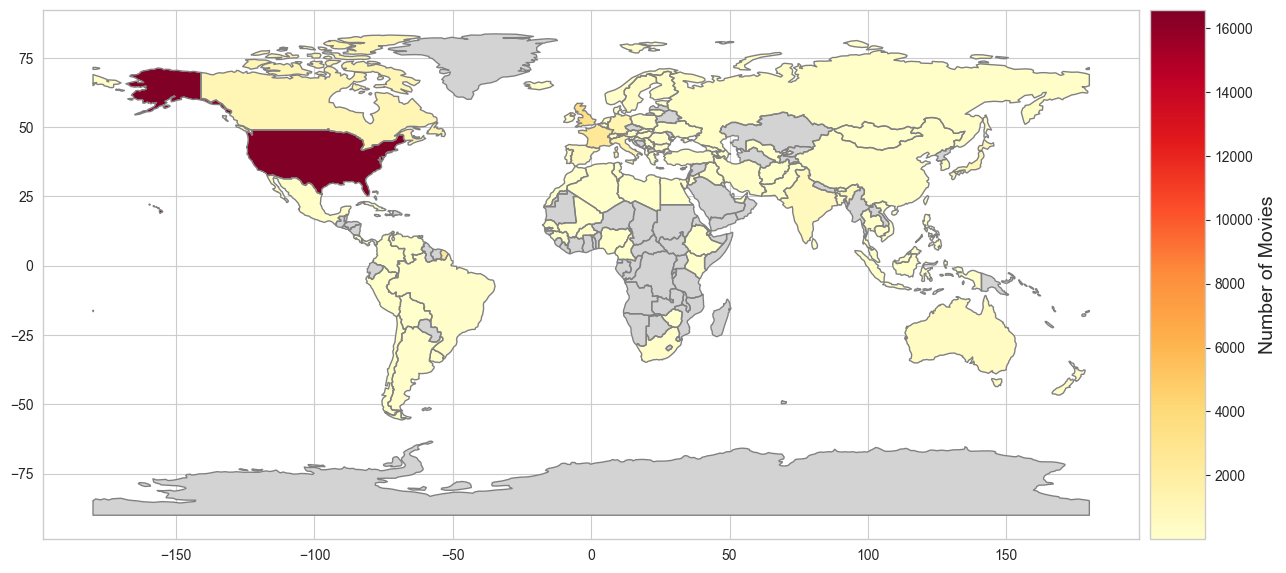

In [120]:
create_world_map(merged, 'count', world)

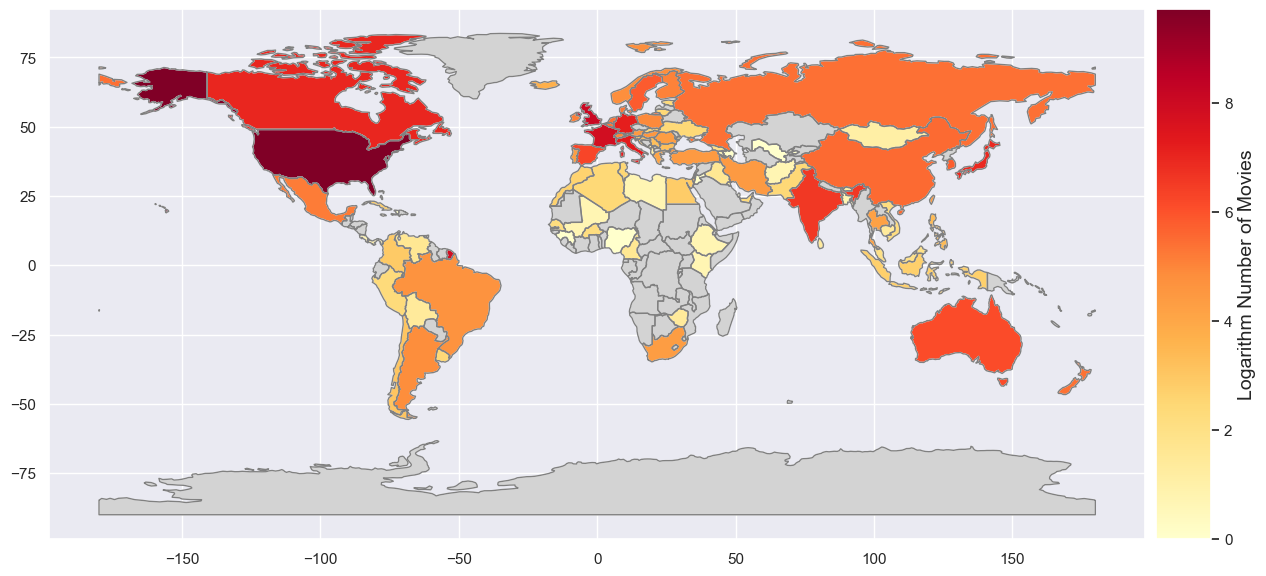

In [345]:
merged['log_count'] = np.log(merged['count'])
create_world_map(merged, 'log_count', world, log=True)

TO DO: write something about the results

#### _Runtime_

In [132]:
df_runtime = pd.DataFrame(df_final_dataset['runtime_clean'])

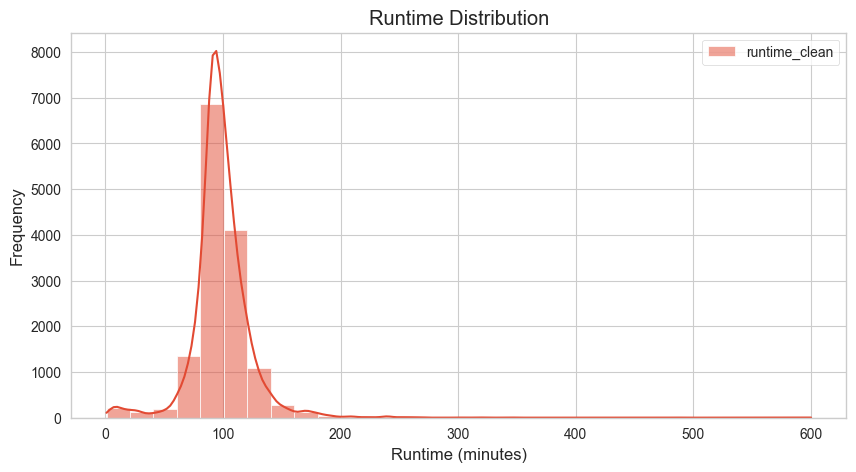

In [133]:
plt.figure(figsize=(10, 5))
sns.histplot(df_runtime.dropna(), bins=30, kde=True)
plt.title('Runtime Distribution')
plt.xlabel('Runtime (minutes)')
plt.ylabel('Frequency')
plt.show()

In [134]:
df_runtime.describe()

,runtime_clean
count,14438.000000
mean,98.223784
std,25.490286
min,1.000000
25%,88.000000
50%,96.000000
75%,108.000000
max,600.000000


In [139]:
df_final_dataset[df_runtime['runtime_clean'] == 600]

,imdb_id,title,budget,genres_cmu,languages,original_language,spoken_languages,countries,production_companies,plot_summary,overview,tagline,keywords,popularity,vote_average,vote_count,cast,adult,belongs_to_collection,box_office_clean,release_date_clean,runtime_clean,director
5420,tt0220924,New York: A Documentary Film,0,"History, Documentary",English Language,en,0,United States of America,[],NaN,Ric Burns (brother of the famed documentarian ...,NaN,[],0.316897,9.0,1.0,[David Ogden Stiers],False,NaN,NaN,1999-11-14,600.0,NaN


[Wikipedia](https://en.wikipedia.org/wiki/New_York:_A_Documentary_Film)

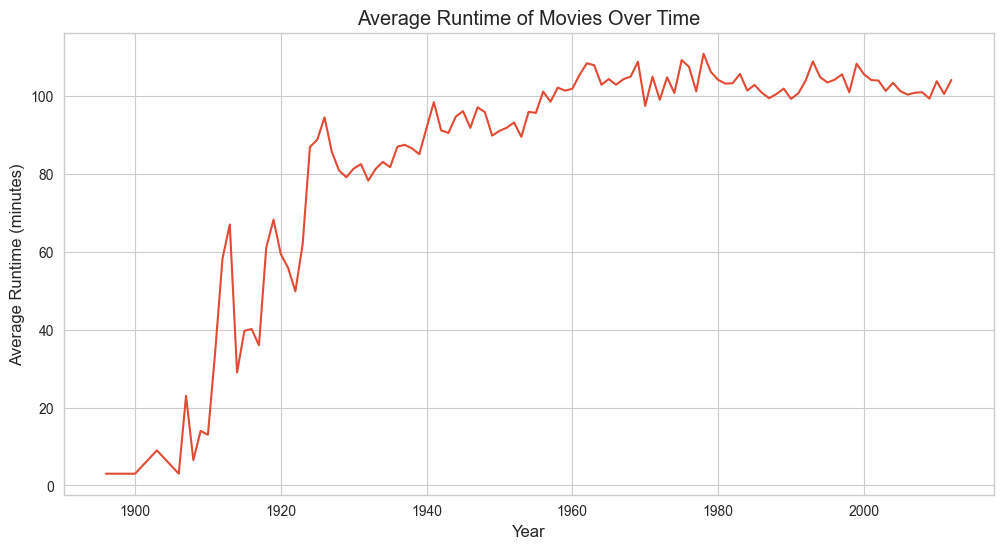

In [238]:
runtime_over_time = df_final_dataset.groupby(df_final_dataset['release_date_clean'].dt.year)['runtime_clean'].mean()
plt.figure(figsize=(12, 6))
sns.lineplot(x=runtime_over_time.index, y=runtime_over_time.values)
plt.title('Average Runtime of Movies Over Time')
plt.xlabel('Year')
plt.ylabel('Average Runtime (minutes)')
plt.show()

#### _Box office_

In [140]:
df_box_office = pd.DataFrame(df_final_dataset['box_office_clean'])

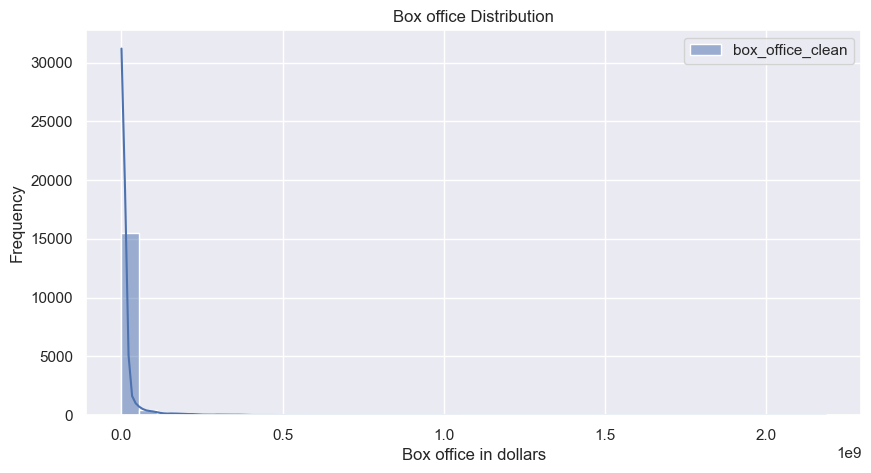

In [348]:
plt.figure(figsize=(10, 5))
sns.histplot(df_box_office.dropna(), bins=40, kde=True)
plt.title('Box office Distribution')
plt.xlabel('Box office in dollars')
plt.ylabel('Frequency')
plt.show()

In [150]:
df_box_office.describe()

,box_office_clean
count,1.650400e+04
mean,1.453155e+07
std,6.915407e+07
min,0.000000e+00
25%,9.300000e+01
50%,1.090000e+02
75%,8.690430e+05
max,2.185372e+09


#### _Language of the movies_

In [269]:
df_languages = df_final_dataset['languages'].str.split(', ', expand=True).stack().reset_index(level=1, drop=True)
df_languages

0        English Language
1        English Language
2        English Language
3        English Language
4        English Language
               ...       
27325    English Language
27326    Russian Language
27327    Russian Language
27327    English Language
27328    English Language
Length: 32446, dtype: object

In [272]:
language_counts_df = df_languages.value_counts().reset_index(name='count').rename(columns={'index': 'language'})
language_counts_df

,language,count
0,English Language,19414
1,French Language,2020
2,Italian Language,1164
3,Spanish Language,1099
4,Japanese Language,973
...,...,...
190,Fulfulde,1
191,Adamawa Language,1
192,Tzotzil language,1
193,Nahuatl languages,1


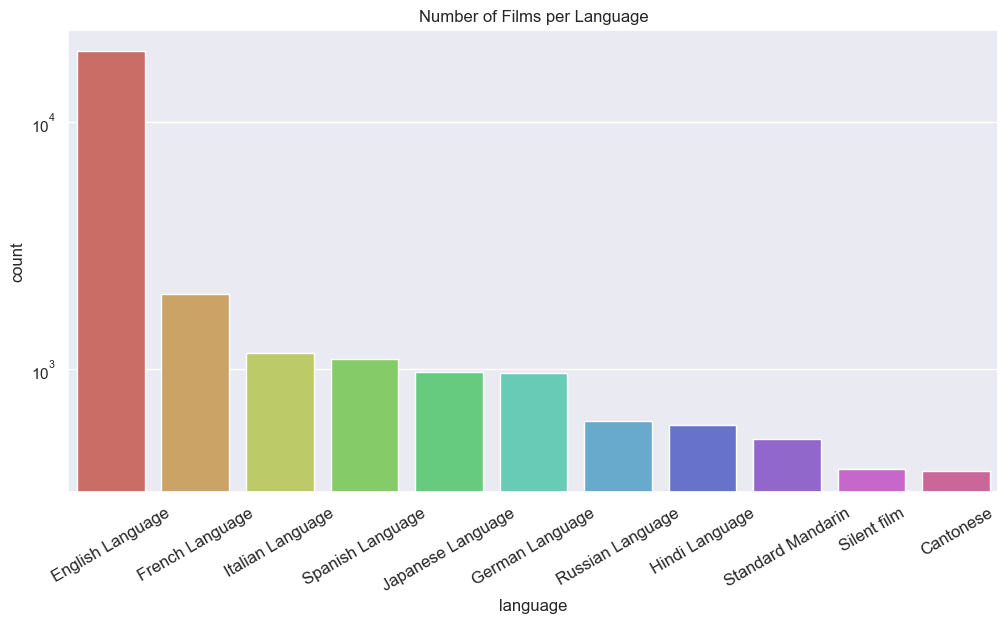

In [296]:
# Assuming you have the 'language_counts_df' DataFrame
colors = sns.color_palette("hls", len(language_counts_df.loc[:10]))

plt.figure(figsize=(12, 6))
sns.barplot(x='language', y='count', data=language_counts_df.loc[:10], 
           palette=colors, hue='language', legend=False)
plt.title('Number of Films per Language')
plt.xticks(rotation=30, fontsize=12)
plt.yscale('log')
plt.show()

#### _Release Date_

In [297]:
month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
day_order = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

In [298]:
df_final_dataset['release_date_clean'] = pd.to_datetime(df_final_dataset['release_date_clean'], errors='coerce')
df_final_dataset['day'] = df_final_dataset['release_date_clean'].dt.day
df_final_dataset['day'] = df_final_dataset['day'].fillna(0).astype(int)
df_final_dataset['month'] = df_final_dataset['release_date_clean'].dt.month
df_final_dataset['month'] = df_final_dataset['month'].fillna(0).astype(int)
df_final_dataset['year'] = df_final_dataset['release_date_clean'].dt.year
df_final_dataset['year'] = df_final_dataset['year'].fillna(0).astype(int)

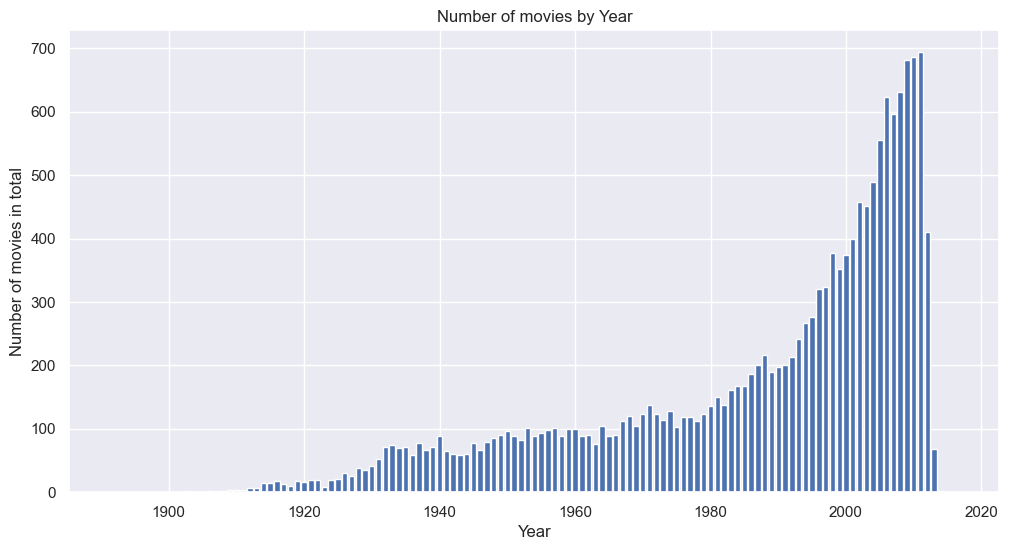

In [343]:
year_occurrences = df_final_dataset['release_date_clean'].dt.year.value_counts().sort_index()

# Plot the histogram
plt.figure(figsize=(12, 6))
plt.bar(year_occurrences.index, year_occurrences.values)
plt.xlabel('Year')
plt.ylabel('Number of movies in total')
plt.title('Number of movies by Year')
plt.xticks(rotation=0)  # Rotate x-axis labels if needed
plt.show()

In [243]:
month_counts = df_final_dataset[df_final_dataset['month'].between(1, 12)]['month'].value_counts().sort_index()
month_mean = df_final_dataset[(df_final_dataset['box_office_clean'] > 1e8) & (df_final_dataset['month'].between(1, 12))] \
                               .groupby('month')['box_office_clean'].mean()
df_months_and_counts = pd.DataFrame({'month': month_counts.index, 'count': month_counts.values, 'box_office': month_mean.values})

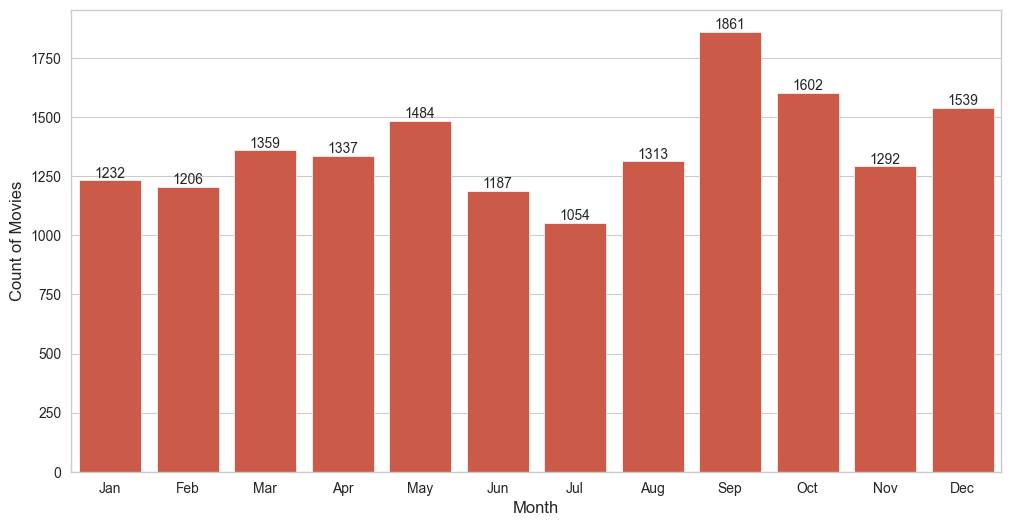

In [244]:
colors = sns.color_palette("husl", len(df_months_and_counts))

plt.figure(figsize=(12, 6))
ax = sns.barplot(
    data=df_months_and_counts,
    x='month', 
    y='count',  # Use the colors list here
)

ax.bar_label(ax.containers[0], fontsize=10)

# Set plot title and labels
plt.xlabel("Month")
plt.ylabel("Count of Movies")
plt.xticks(ticks=range(12), labels=["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])

# Show the plot
plt.show()

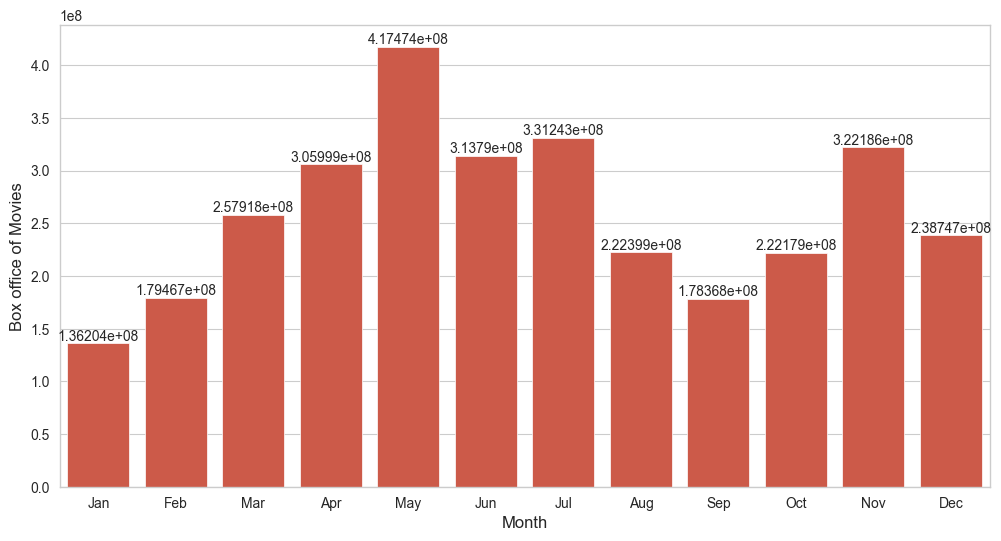

In [245]:
plt.figure(figsize=(12, 6))
ax = sns.barplot(
    data=df_months_and_counts,
    x='month', 
    y='box_office',  # Use the colors list here
)

ax.bar_label(ax.containers[0], fontsize=10)

# Set plot title and labels
plt.xlabel("Month")
plt.ylabel("Box office of Movies")
plt.xticks(ticks=range(12), labels=["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])

# Show the plot
plt.show()

In [246]:
months = {'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6, 'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12}

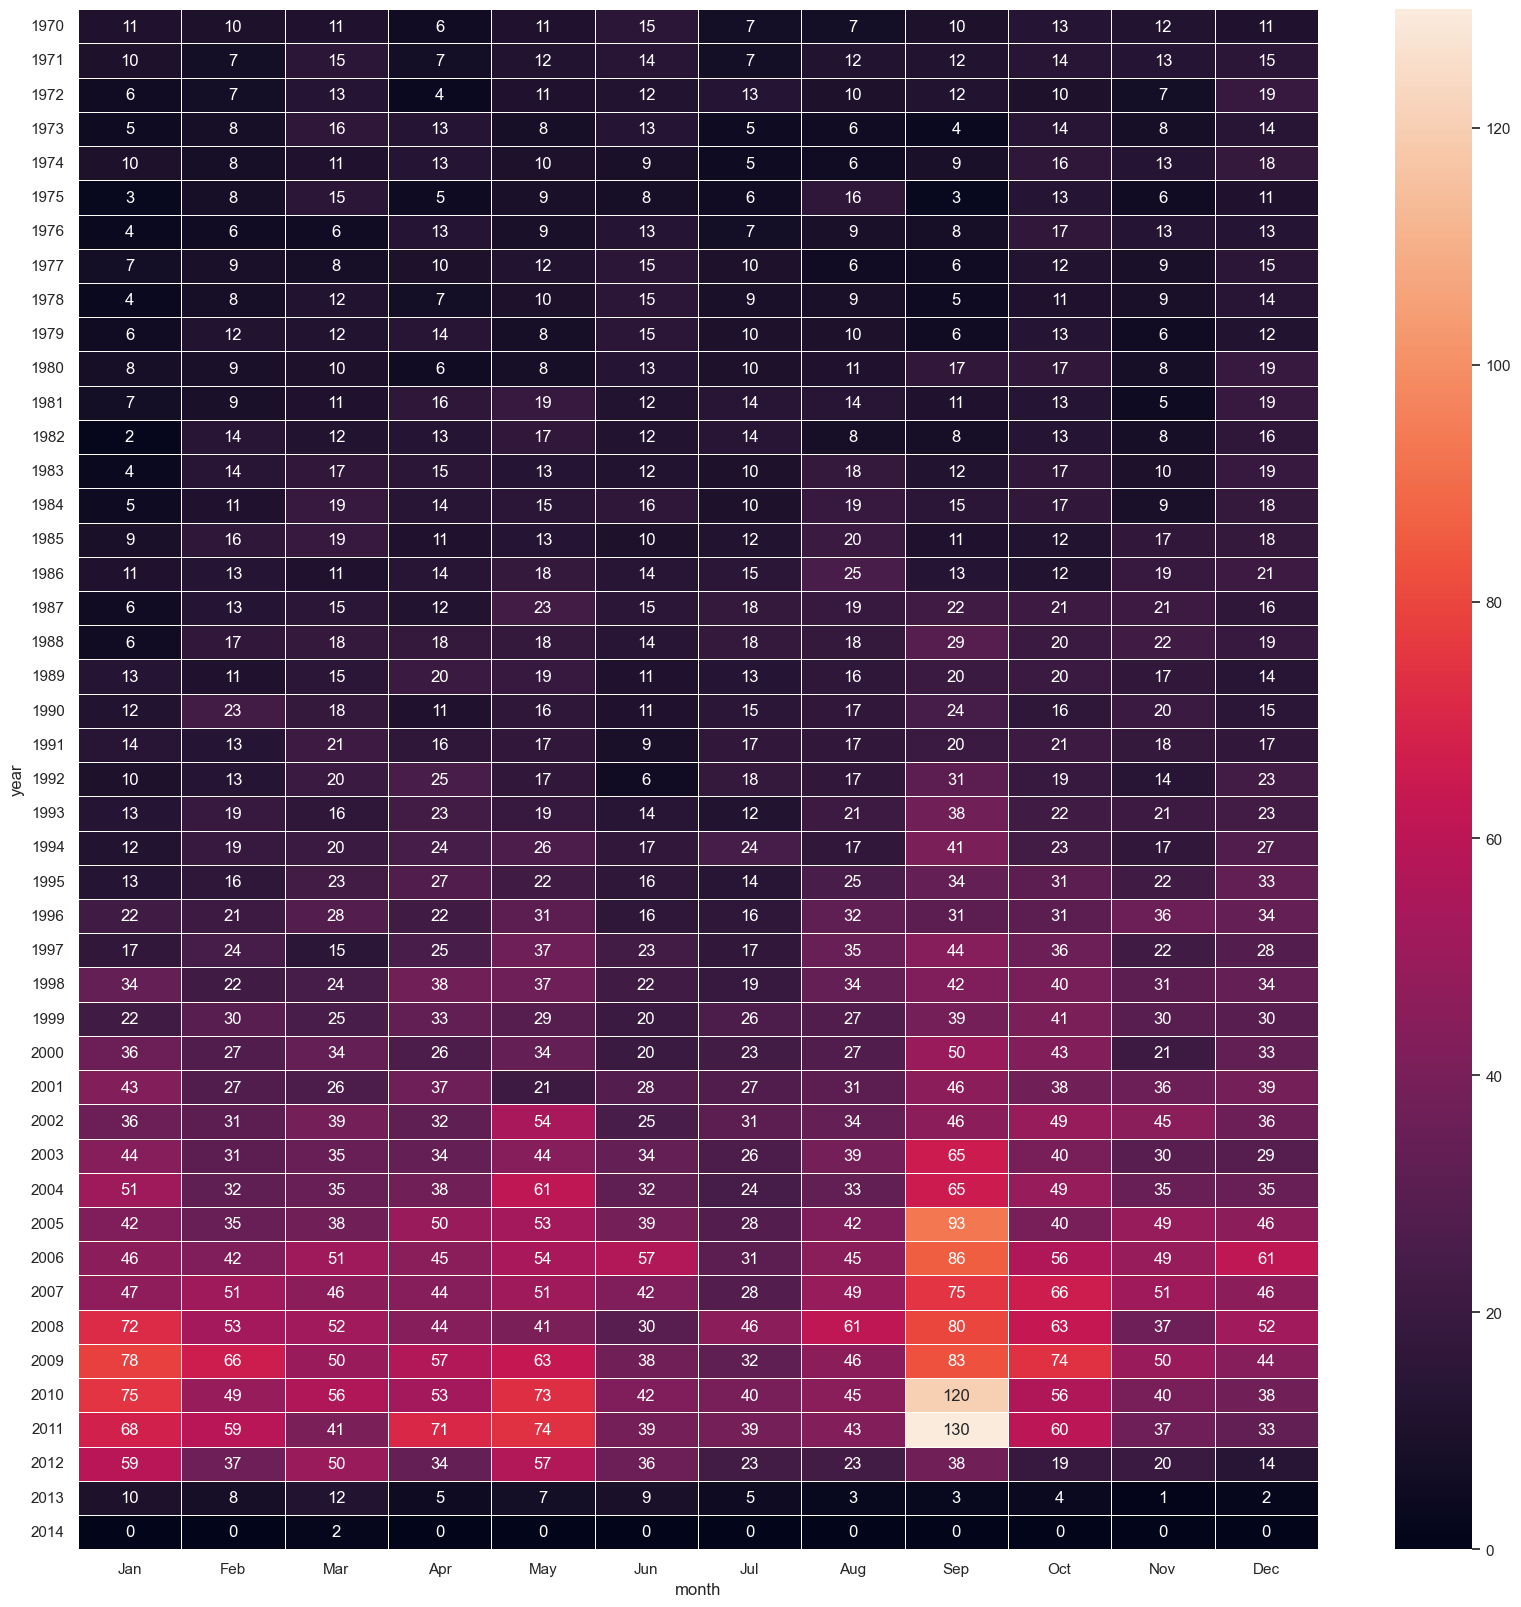

In [262]:
# Create the pivot table with months as columns and years as rows
df_tmp = df_final_dataset[(df_final_dataset['year'] >=1970) & (df_final_dataset['year'] <=2014) ]
hmap_21 = pd.pivot_table(data=df_tmp, index='year', columns='month', aggfunc='count', values='title')
hmap_21 = hmap_21.fillna(0)

# Set the font scale for better readability
sns.set(font_scale=1)

# Create the plot
f, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(hmap_21, annot=True, linewidths=.5, ax=ax, fmt='g', xticklabels=["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])
plt.yticks(rotation=0)
# Display the plot
plt.show()

Correlation coefficient: 0.57


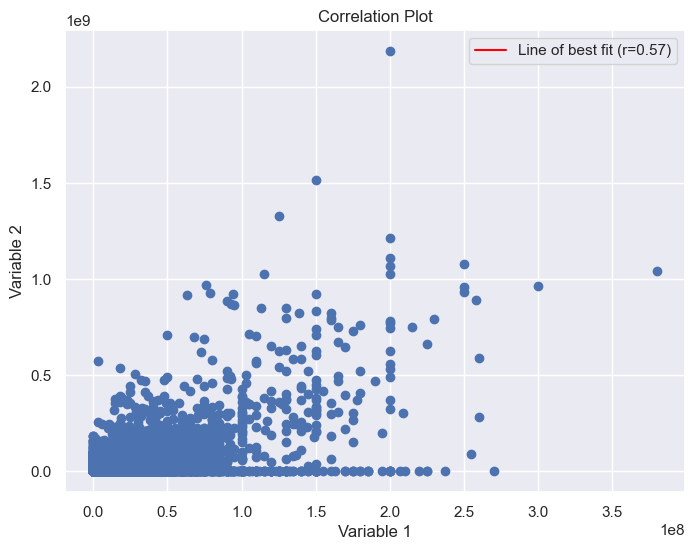

In [263]:
# Assuming you have a DataFrame 'df' with columns 'var1' and 'var2'
plt.figure(figsize=(8, 6))
plt.scatter(df_final_dataset['budget'], df_final_dataset['box_office_clean'])

# Calculate the correlation coefficient
correlation = df_final_dataset['budget'].corr(df_final_dataset['box_office_clean'])
print(f'Correlation coefficient: {correlation:.2f}')

# Add a line of best fit
z = np.polyfit(df_final_dataset['budget'], df_final_dataset['box_office_clean'], 1)
p = np.poly1d(z)
plt.plot(df_final_dataset['budget'], p(df_final_dataset['budget']), color='red', label=f'Line of best fit (r={correlation:.2f})')

plt.xlabel('Variable 1')
plt.ylabel('Variable 2')
plt.title('Correlation Plot')
plt.legend()
plt.show()

#### _Correlation between the features_

In [193]:
df_corr = df_final_dataset[['day', 'month', 'year', 'box_office_clean', 'runtime_clean', 'popularity', 'vote_average', 'vote_count']]
df_corr

,day,month,year,box_office_clean,runtime_clean,popularity,vote_average,vote_count
0,24,8,2001,14010832.0,98.0,7.058599,4.8,299.0
1,0,0,0,NaN,110.0,3.121105,5.7,15.0
2,16,8,1938,3600000.0,106.0,0.632261,4.8,6.0
3,0,0,0,NaN,76.0,1.514972,6.5,34.0
4,4,4,1997,93.0,NaN,0.036814,6.0,1.0
...,...,...,...,...,...,...,...,...
27324,2,12,1994,NaN,NaN,0.036471,5.0,1.0
27325,3,5,1941,82.0,NaN,0.431908,6.0,9.0
27326,0,0,0,NaN,26.0,0.921068,6.6,8.0
27327,18,10,2007,132.0,NaN,0.471086,5.6,5.0


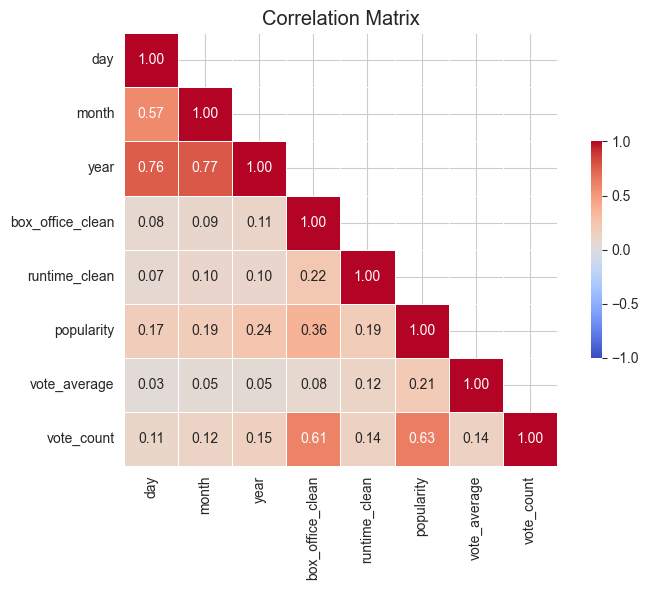

In [196]:
correlation_matrix = df_corr.corr()

# Create a mask for the upper triangle
mask = np.triu(np.ones_like(correlation_matrix), k=1)

# Set up the matplotlib figure
plt.figure(figsize=(8, 6))

# Create a heatmap
sns.heatmap(correlation_matrix, 
            annot=True,  # Show correlation values
            cmap='coolwarm',  # Color scheme
            center=0,  # Center the colorbar at 0
            vmin=-1, vmax=1,  # Set the range of correlations
            mask=mask,  # Apply the mask to show only lower triangle
            fmt='.2f',  # Format correlation values to 2 decimal places
            square=True,  # Make cells square
            linewidths=0.5,  # Add grid lines
            cbar_kws={'shrink': .5})  # Adjust colorbar size

plt.title('Correlation Matrix')
plt.tight_layout()

## 3. Demographic Recommandation System
<a id='section-3'></a>

In [190]:
df_ratings = pd.read_csv('TMdB_Movielens_combined/ratings.csv')
df_links = pd.read_csv('TMdB_Movielens_combined/links.csv')

In [191]:
df_links.shape

(45843, 3)

In [192]:
df_ratings.shape

(26024289, 4)

In [193]:
df_ratings

,userId,movieId,rating,timestamp
0,1,110,1.0,1425941529
1,1,147,4.5,1425942435
2,1,858,5.0,1425941523
3,1,1221,5.0,1425941546
4,1,1246,5.0,1425941556
...,...,...,...,...
26024284,270896,58559,5.0,1257031564
26024285,270896,60069,5.0,1257032032
26024286,270896,63082,4.5,1257031764
26024287,270896,64957,4.5,1257033990


In [187]:
df_final_dataset.shape

(27329, 23)

In [186]:
df_links.shape

(45843, 3)

In [180]:
df_final_dataset['imdb_id'] = df_final_dataset['imdb_id'].str.replace("tt", "").astype(int)

In [194]:
df_ratings_with_imdb_id = pd.merge(df_ratings, df_links, on='movieId', how='left')

In [195]:
df_ratings_with_imdb_id.shape

(26024289, 6)

In [197]:
df_ratings_with_imdb_id.head(2)

,userId,movieId,rating,timestamp,imdbId,tmdbId
0,1,110,1.0,1425941529,112573,197.0
1,1,147,4.5,1425942435,112461,10474.0


In [198]:
df_ratings_with_imdb_id = df_ratings_with_imdb_id[df_ratings_with_imdb_id['imdbId'].isin(df_final_dataset['imdb_id'].unique())]

In [204]:
df_ratings_with_imdb_id.head(2)

,userId,movieId,rating,timestamp,imdbId,tmdbId
0,1,110,1.0,1425941529,112573,197.0
1,1,147,4.5,1425942435,112461,10474.0


## 4. Collaborative filtering Recommandation System
<a id='section-4'></a>

## 5. Content-based filtering Recommandation System
<a id='section-5'></a>

## 6. Hybrid filtering Recommandation System
<a id='section-6'></a>